# Model Selection

In [1]:
%load_ext autoreload
%autoreload 2  

import os
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("..")

from modules.inference.model import Detector
from modules.inference.nms import NMS
from modules.utils.metrics import evaluate_detections, calculate_precision_recall_curve, calculate_map_x_point_interpolated

#### **Task 5: Assignment Instructions:**
A. Compare and contrast the performance of YOLO Model 1 and YOLO Model 2 by demonstrating the weaknesses and strengths of each model. 
B. Finally, select the best model and state the reasons why this model is best suited for the TechTrack's system implementation.

**Reminder:**  
- Your notebook should be well-structured and clear for effective presentation. Up to 10 points may be deducted for poor structure and clarity.
- Consider this report as if it were being reviewed by **TechTrack stakeholders**. Keep it professional, insightful, and visually organized!
- Use visualizations, tables, and quantitative analysis where applicable to support your findings.

---

### Initialize the required components and default parameters


In [2]:
## Initialize Model 1
WEIGHTS_PATH_1 = "../storage/yolo_model_1/yolov4-tiny-logistics_size_416_1.weights"
CONFIG_PATH_1 = "../storage/yolo_model_1/yolov4-tiny-logistics_size_416_1.cfg"
CLASS_NAMES_PATH_1 = "../storage/yolo_model_1/logistics.names"
SCORE_THRESHOLD = 0.2

print("[INFO] Loading YOLO Model 1...")
detector_1 = Detector(WEIGHTS_PATH_1, CONFIG_PATH_1, CLASS_NAMES_PATH_1, SCORE_THRESHOLD)
print("[INFO] Model 1 loaded successfully.")

## Initialize Model 2
WEIGHTS_PATH_2 = "../storage/yolo_model_2/yolov4-tiny-logistics_size_416_2.weights"
CONFIG_PATH_2 = "../storage/yolo_model_2/yolov4-tiny-logistics_size_416_2.cfg"
CLASS_NAMES_PATH_2 = "../storage/yolo_model_2/logistics.names"

print("[INFO] Loading YOLO Model 2...")
detector_2 = Detector(WEIGHTS_PATH_2, CONFIG_PATH_2, CLASS_NAMES_PATH_2, SCORE_THRESHOLD)
print("[INFO] Model 2 loaded successfully.")


## Initialize NMS
IOU_THRESHOLD = 0.5
print("[INFO] Initializing Non-Maximum Suppression...")
nms = NMS(SCORE_THRESHOLD, IOU_THRESHOLD)
print("[INFO] NMS initialized.")

# Initialize default params
DATA_DIR = "../storage/logistics"
NUM_CLASSES = 20
MAP_IOU_THRESHOLD = 0.5

[INFO] Loading YOLO Model 1...
[INFO] Model 1 loaded successfully.
[INFO] Loading YOLO Model 2...
[INFO] Model 2 loaded successfully.
[INFO] Initializing Non-Maximum Suppression...
[INFO] NMS initialized.


In [ ]:
# Helper function to get annotation from given file_path
def get_annotations(file_path, img_height, img_width):
    bboxes = []
    class_labels = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            box = list(map(float, parts[1:]))
            box = box * np.array([img_width, img_height, img_width, img_height])
            (centerX, centerY, width, height) = box.astype("int")
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))
            box = tuple([x, y, int(width), int(height)])
            bboxes.append(box)
            
            class_label = int(parts[0])
            class_labels.append(class_label)
            
    return bboxes, class_labels

# Function to process image and annotation files for precision-recall curve
def get_precision_recall_curve(data_dir, detector): 
    pred_bboxes, pred_class_ids, pred_confidence_scores, pred_class_scores = [], [], [], []
    gt_boxes, gt_classes = [], []

    for i, (image_file, annotation_file) in enumerate(zip(
                    sorted(glob(os.path.join(data_dir, "*.jpg"))),
                    sorted(glob(os.path.join(data_dir, "*.txt"))))):
        
        image = cv2.imread(image_file)
        img_height, img_width = image.shape[:2]

        # Get predictions
        raw_prediction = detector.predict(image)
        bboxes, class_ids, confidence_scores, class_scores = detector.post_process(raw_prediction)
        
        # Filter predictions with the same NMS setting
        filtered_bboxes, filtered_class_ids, filtered_scores, filtered_class_scores = nms.filter(bboxes, class_ids, confidence_scores, class_scores)
        filtered_bboxes = [tuple(b) for b in filtered_bboxes]

        pred_bboxes.append(filtered_bboxes)
        pred_class_ids.append(filtered_class_ids)
        pred_confidence_scores.append(filtered_scores)
        pred_class_scores.append(filtered_class_scores)

        # Get annotations
        gt_boxes.append(get_annotations(annotation_file, img_height, img_width)[0])
        gt_classes.append(get_annotations(annotation_file, img_height, img_width)[1])


    # Generate precision recall curves
    y_true, pred_scores = evaluate_detections(pred_bboxes, pred_class_ids, pred_confidence_scores, pred_class_scores, 
                                            gt_boxes, gt_classes, MAP_IOU_THRESHOLD, NUM_CLASSES, eval_type="class_scores"
                                            )
    precision_dict, recall_dict, thresholds_dict = calculate_precision_recall_curve(y_true, pred_scores, NUM_CLASSES)

    return precision_dict, recall_dict, thresholds_dict

# Function to calculate the mAP using x-point interpolation for multi-class object detection tasks.
def get_mAP(precision_dict, recall_dict):
    precision_recall_points = {
        class_index: list(zip(recall_dict[class_index], precision_dict[class_index]))
        for class_index in range(NUM_CLASSES)
    }
    mean_average_precisions, overall_map = calculate_map_x_point_interpolated(precision_recall_points, NUM_CLASSES, num_interpolated_points=11)

    return mean_average_precisions, overall_map

# Function to plot Precision-Recall curves for multiple classes as subplots.
def plot_precision_recall_curves(precision_dict, recall_dict, thresholds_dict, model_name):
    from sklearn.metrics import auc
    cols = 5
    rows = 4

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()  # Flatten in case of single row or column

    for i, class_id in enumerate(precision_dict.keys()):
        precisions = precision_dict[class_id]
        recalls = recall_dict[class_id]
        thresholds = thresholds_dict[class_id]
        pr_auc = auc(recalls, precisions)

        ax = axes[i]
        ax.plot(recalls, precisions, marker='o', label=f'Class {class_id}', color='b')
        ax.fill_between(recalls, precisions, alpha=0.2, color="b", label=f'AUC={pr_auc:.2f}')


        # Annotate some threshold values for reference
        for j in range(0, len(thresholds), max(1, len(thresholds) // 10)):  # Pick 10 threshold points
            ax.annotate(f'{thresholds[j]:.2f}', 
                        (recalls[j], precisions[j]), 
                        textcoords="offset points",
                        xytext=(-10,10),
                        ha='center',
                        fontsize=8,
                        color='red')

        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.set_title(f"Class {class_id}")
        ax.legend()
        ax.grid(True)


    plt.suptitle(f"{model_name}: Precision-Recall Curve")
    plt.tight_layout()
    plt.show()


#### **Task A:**
**Compare and contrast the performance of YOLO Model 1 and YOLO Model 2 by demonstrating the weaknesses and strengths of each model.**

In [4]:
precision_dict_1, recall_dict_1, thresholds_dict_1 = get_precision_recall_curve(DATA_DIR, detector_1)
mean_average_precisions_1, overall_map_1 = get_mAP(precision_dict_1, recall_dict_1)


precision_dict_2, recall_dict_2, thresholds_dict_2 = get_precision_recall_curve(DATA_DIR, detector_2)
mean_average_precisions_2, overall_map_2 = get_mAP(precision_dict_2, recall_dict_2)

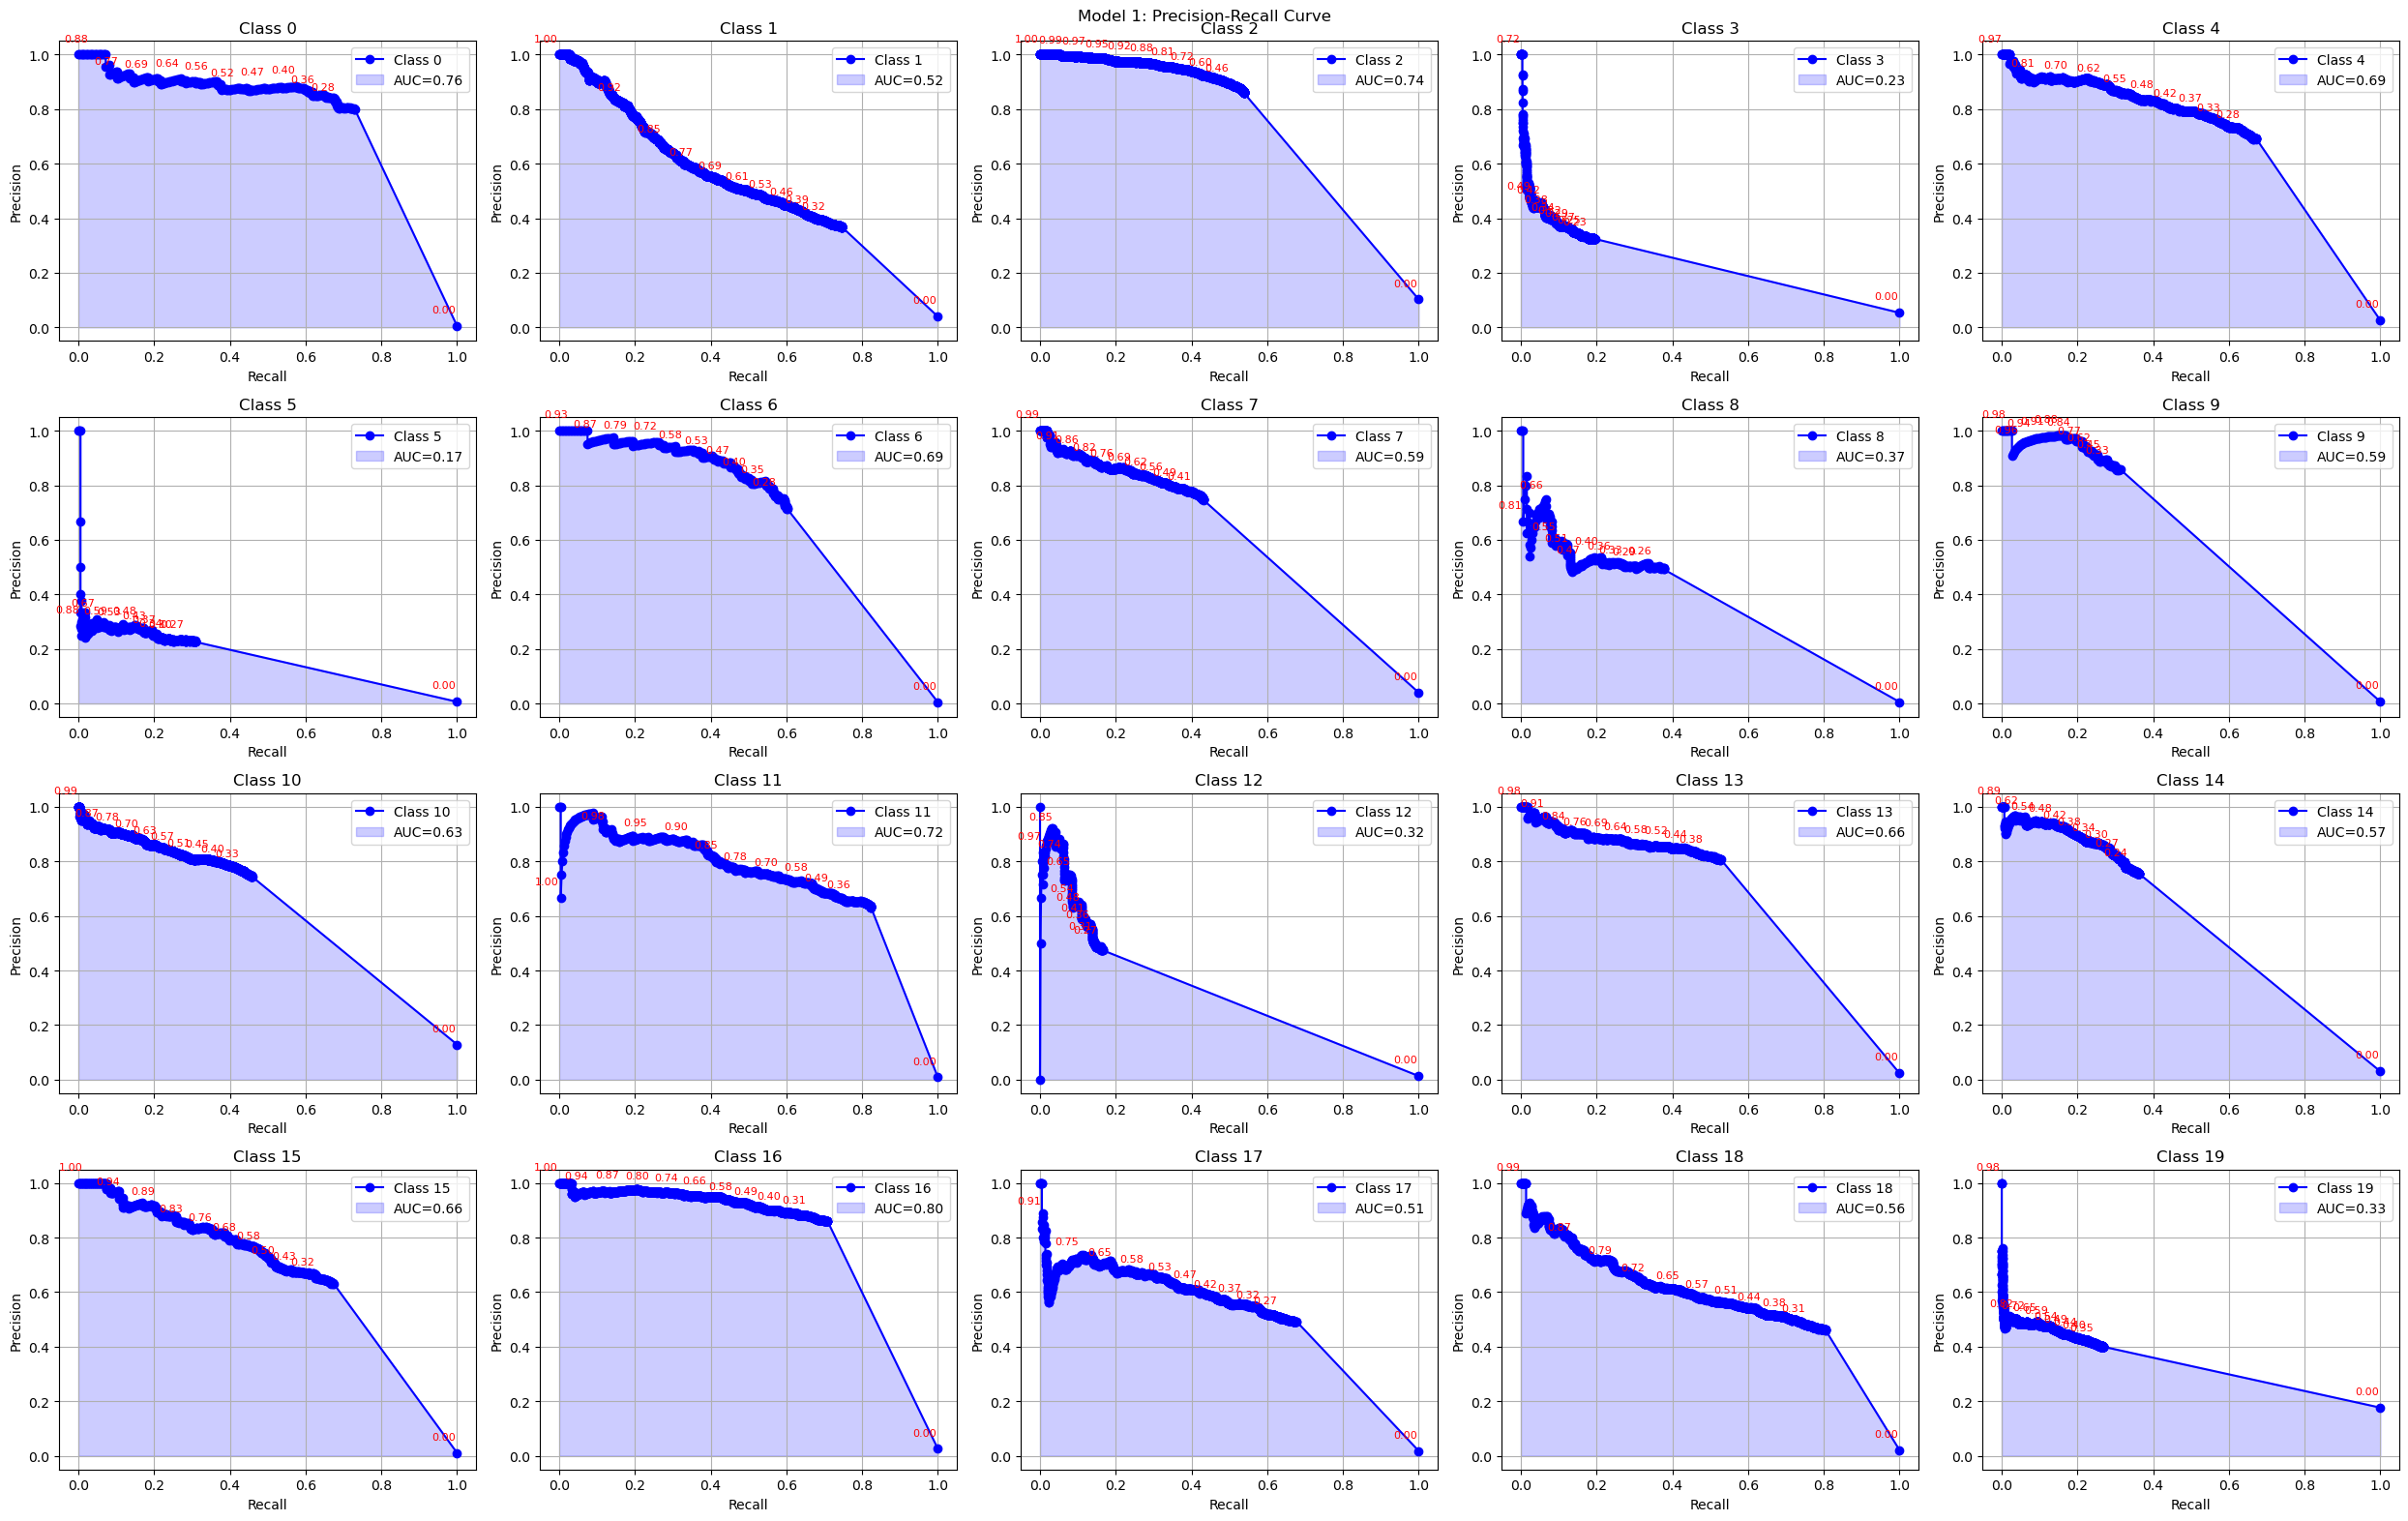

In [15]:
plot_precision_recall_curves(precision_dict_1, recall_dict_1, thresholds_dict_1, "Model 1")

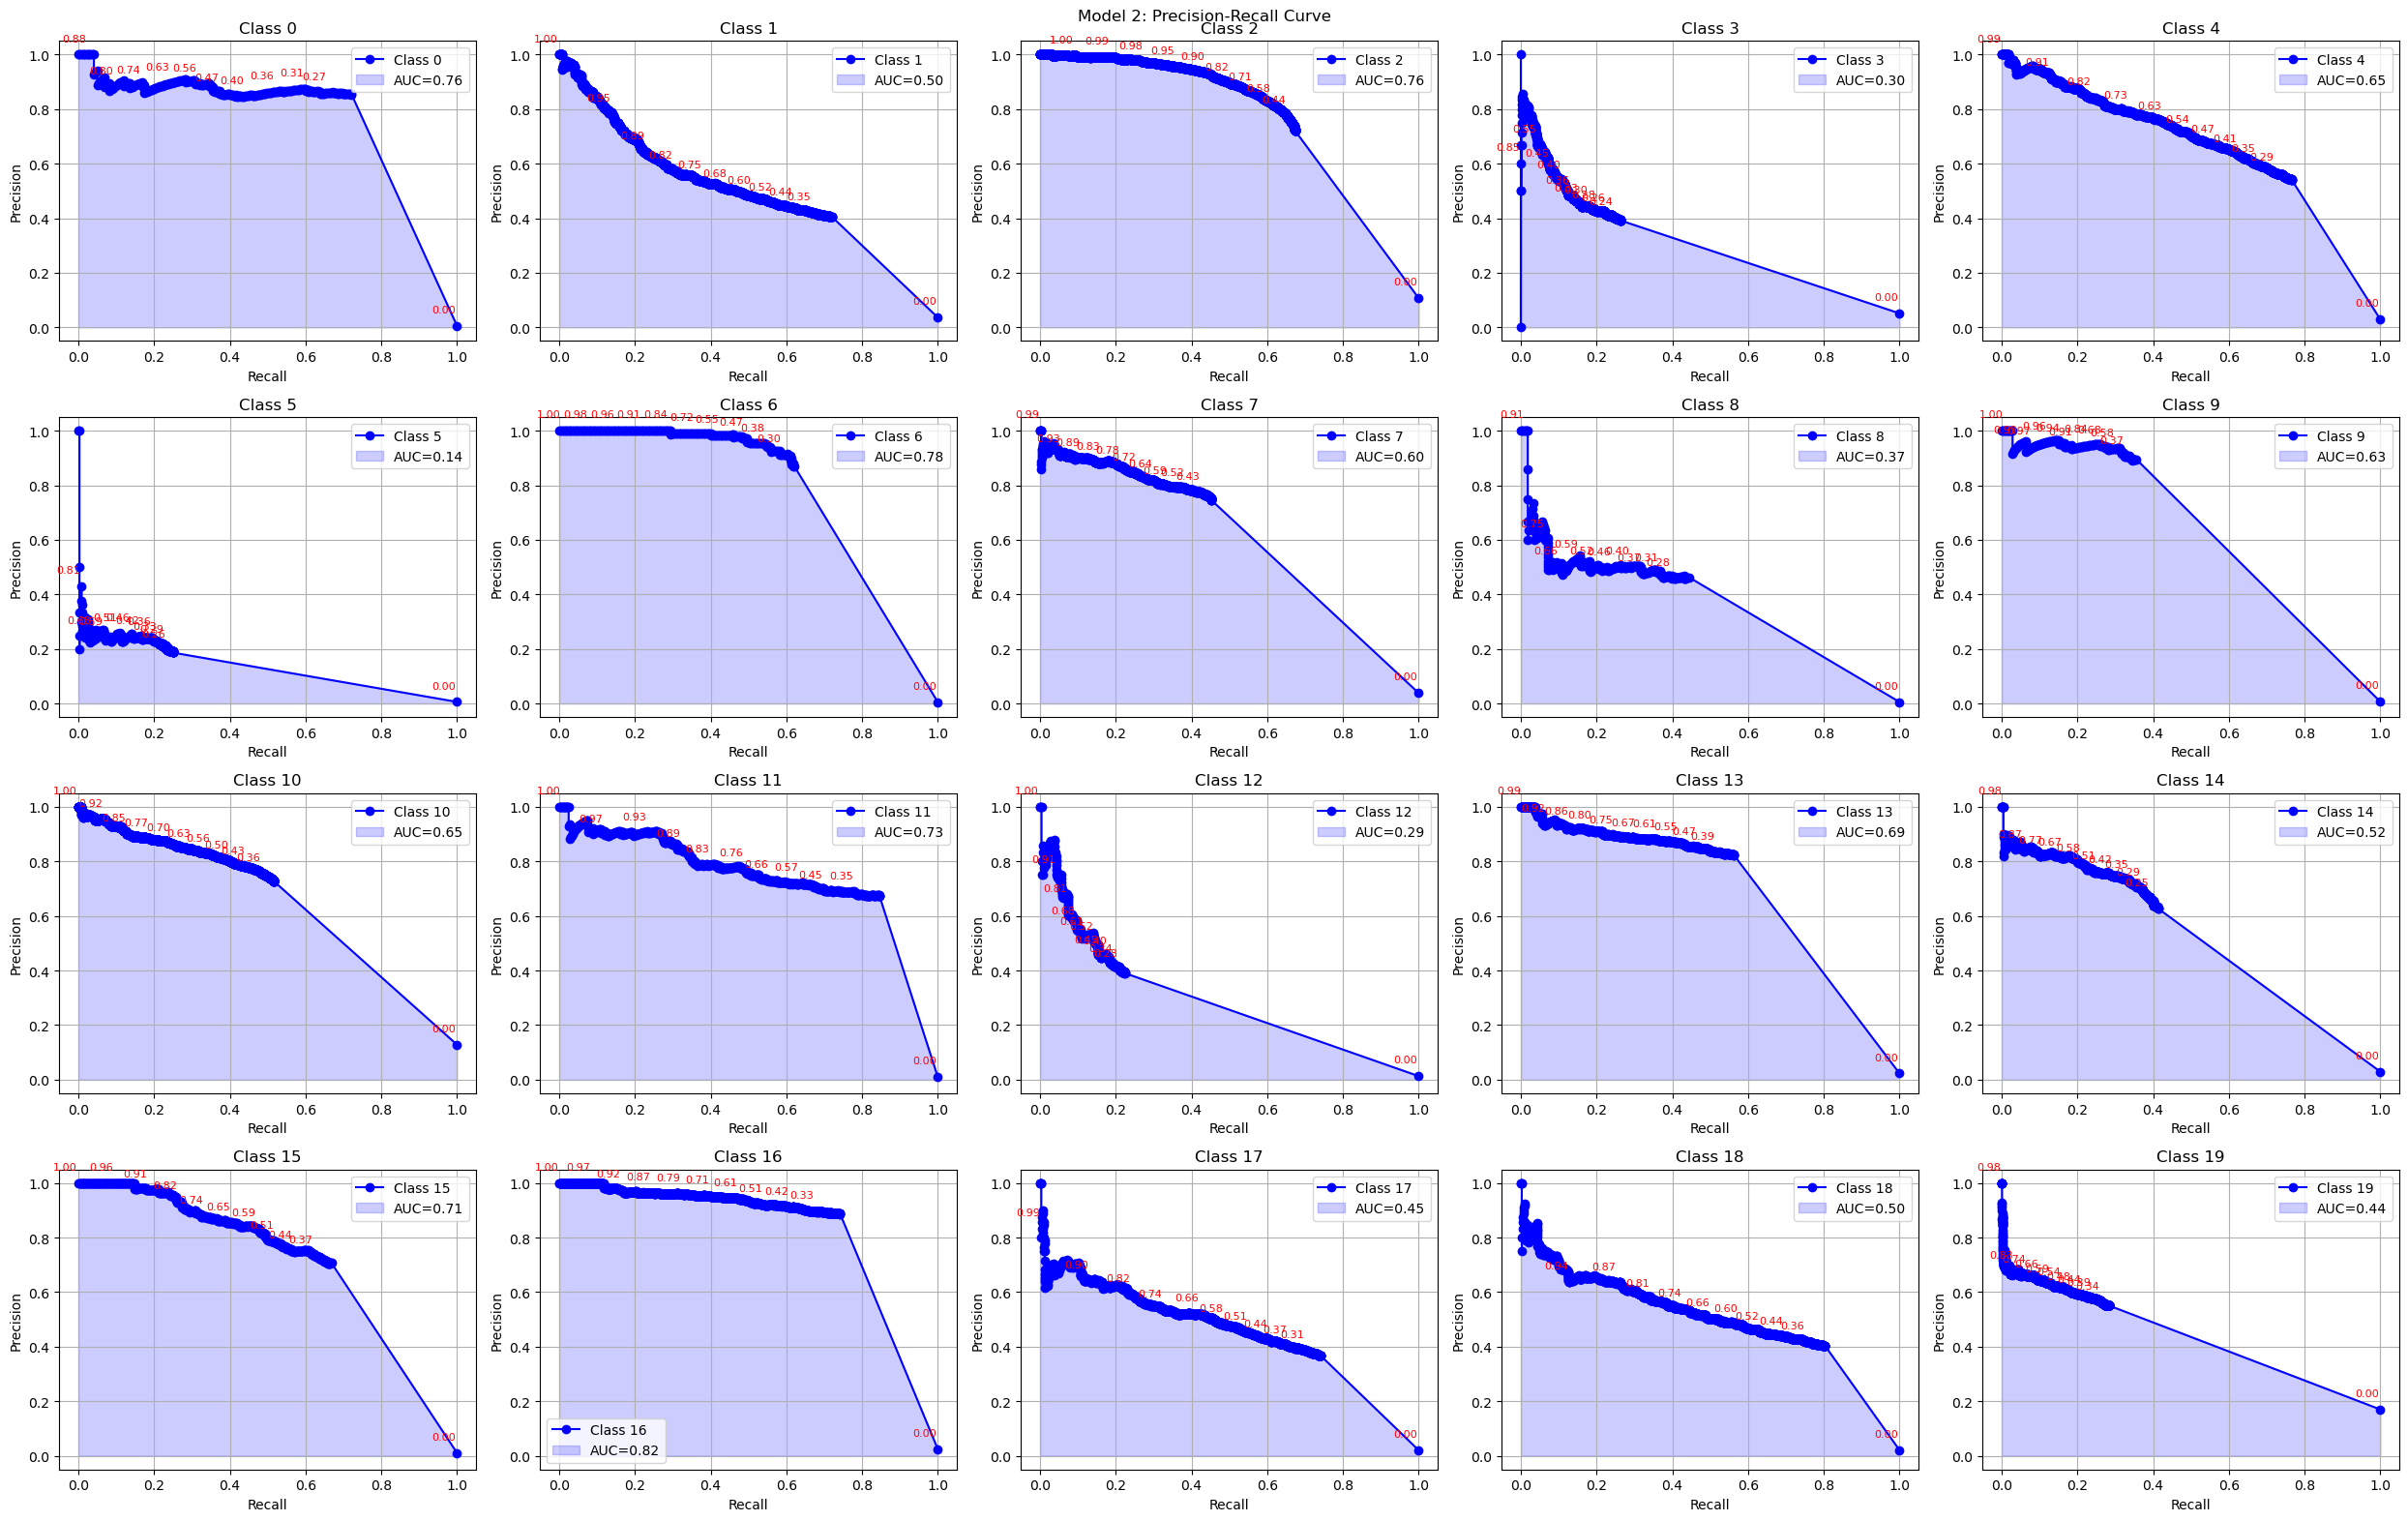

In [13]:
plot_precision_recall_curves(precision_dict_2, recall_dict_2, thresholds_dict_2, "Model 2")

From the PR-Curve figures above, the two models show similar patterns for most of the classes. However, there are some slight differences based on the observations.

**Overall Precision-Recall Shape**
* Model 2 is more stable PR curves indicate better confidence in predictions. It seems to have less drastic precision drops for some classes.
* Model 2 outperforms Model 1 in 9 classes in terms of AUC.

**Low-Performing Classes**
* Some classes have very low AP values in both models, showing challenges in detecting those classes.
* Example:
    * Class 12: Both models have low AUC (~0.3), indicating weak detection performance.
    * Class 5: Both models have low AUC (Model 2: 0.14, Model 1: 0.17).

In [7]:
# For each class, print the Average Precision for each model
for cls in range(NUM_CLASSES):
    better_model = "Model 1" if mean_average_precisions_1[cls] > mean_average_precisions_2[cls] else "Model 2"
    print(f"Class {cls}: Model 1 Average Precision: {round(mean_average_precisions_1[cls], 4)}; Model 2 Average Precision: {round(mean_average_precisions_2[cls], 4)}; {better_model} is better.")

Class 0: Model 1 Average Precision: 0.6565; Model 2 Average Precision: 0.6569; Model 2 is better.
Class 1: Model 1 Average Precision: 0.4849; Model 2 Average Precision: 0.4629; Model 1 is better.
Class 2: Model 1 Average Precision: 0.5712; Model 2 Average Precision: 0.6413; Model 2 is better.
Class 3: Model 1 Average Precision: 0.1688; Model 2 Average Precision: 0.2166; Model 2 is better.
Class 4: Model 1 Average Precision: 0.5604; Model 2 Average Precision: 0.5842; Model 2 is better.
Class 5: Model 1 Average Precision: 0.1655; Model 2 Average Precision: 0.1401; Model 1 is better.
Class 6: Model 1 Average Precision: 0.5769; Model 2 Average Precision: 0.625; Model 2 is better.
Class 7: Model 1 Average Precision: 0.4201; Model 2 Average Precision: 0.4196; Model 1 is better.
Class 8: Model 1 Average Precision: 0.2444; Model 2 Average Precision: 0.2778; Model 2 is better.
Class 9: Model 1 Average Precision: 0.351; Model 2 Average Precision: 0.3548; Model 2 is better.
Class 10: Model 1 Aver

Based on the AP values across classes, Model 2 is generally better than Model 1 as the former has better performance in 14 classes (out of 20). 


In [6]:
print(f"Overall mAP of YOLO Model 1: {round(overall_map_1, 4)}")
print(f"Overall mAP of YOLO Model 2: {round(overall_map_2, 4)}")

Overall mAP of YOLO Model 1: 0.4435
Overall mAP of YOLO Model 2: 0.459


---

#### **Task B:**
**Select the best model and state the reasons why this model is best suited for the TechTrack's system implementation.**

Given the results above, Model 2 is selected for the TechTrack's system, given its better performance in terms of overall Precision-Recall curve and mAP.

**Comparison Based on mAP**
* Model 2 achieves a higher mean Average Precision (mAP) of 0.4782, compared to 0.4435 for Model 1.
* This suggests that Model 2 generally performs better in terms of precision and recall across all classes.

**Strengths of Model 2**
* Higher mAP indicates better overall detection performance.
* Several classes have improved Precision-Recall (PR) curves, showing higher AUC (area under curve).
* The model appears to have better recall at lower confidence thresholds, meaning it detects more true positives.

**Weaknesses of Model 2**
* Some classes may still show low AP, meaning performance is inconsistent across categories.
* There may be more false positives for certain classes, leading to a trade-off in precision.